# FastNIMeans Denoising

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [1]:
%cd /tf/notebooks

/tf/notebooks


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from skimage.restoration import denoise_bilateral


import cv2
from deepface import DeepFace


In [4]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = Image.open(path).resize(shape)
        img = np.array(img)
        img = preprocessing(img)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [5]:
def fastnimeans_denoising(img):  
    #img = np.array(Image.open(img))
    return cv2.fastNlMeansDenoisingColored(img,  None, 10, 10, 7, 21)

## Example

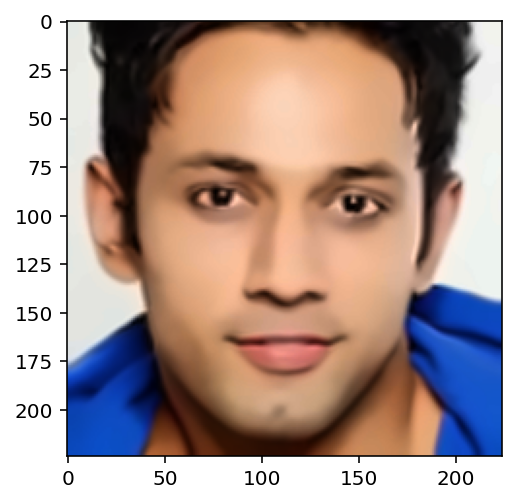

In [8]:
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = fastnimeans_denoising)
plt.imshow(indian_img);

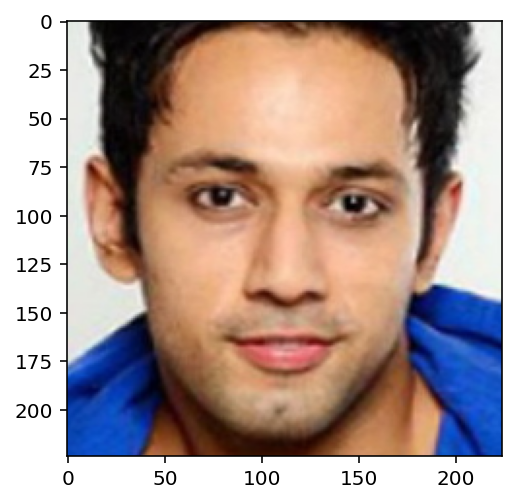

In [9]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img);

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [13]:
facenet_model = "facenet_fastnimeans_denoising"

In [14]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.933004,0.932036,0.933971
0,African,0.915150,0.914060,0.916240
0,Caucasian,0.907265,0.906098,0.908431
0,Asian,0.904552,0.903478,0.905626


In [15]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.838753,0.837465,0.840042
0,African,0.837983,0.836647,0.839320
0,Asian,0.824157,0.822815,0.825498
0,Caucasian,0.773100,0.771568,0.774632


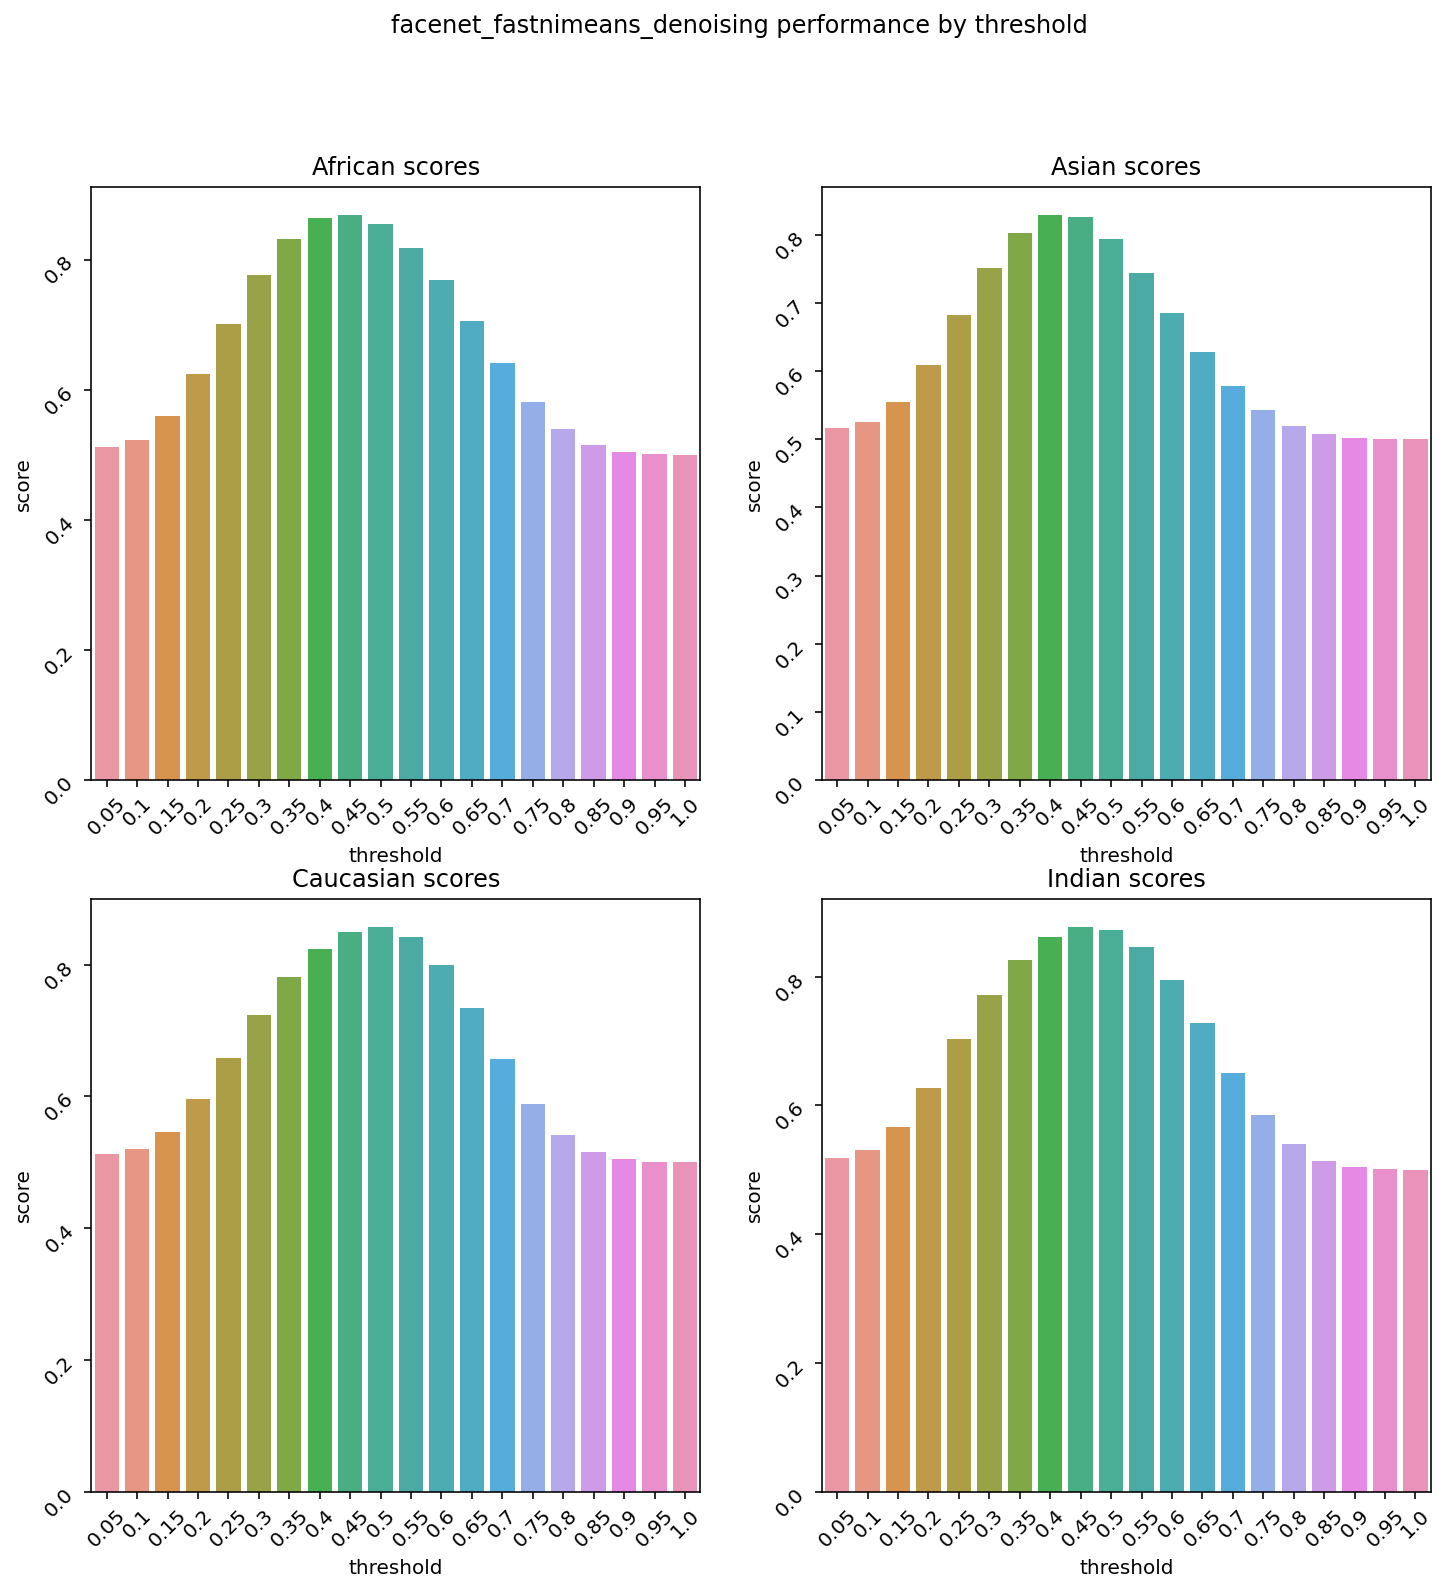

In [16]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [17]:
vgg_face_model = "vgg_face_fastnimeans_denoising"


In [18]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.891571,0.890486,0.892655
0,Asian,0.837817,0.836337,0.839298
0,African,0.837795,0.836384,0.839206
0,Caucasian,0.835885,0.834445,0.837326


In [19]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.775900,0.774491,0.777309
0,Caucasian,0.766153,0.764621,0.767686
0,African,0.709050,0.707469,0.710631
0,Asian,0.649730,0.647922,0.651538


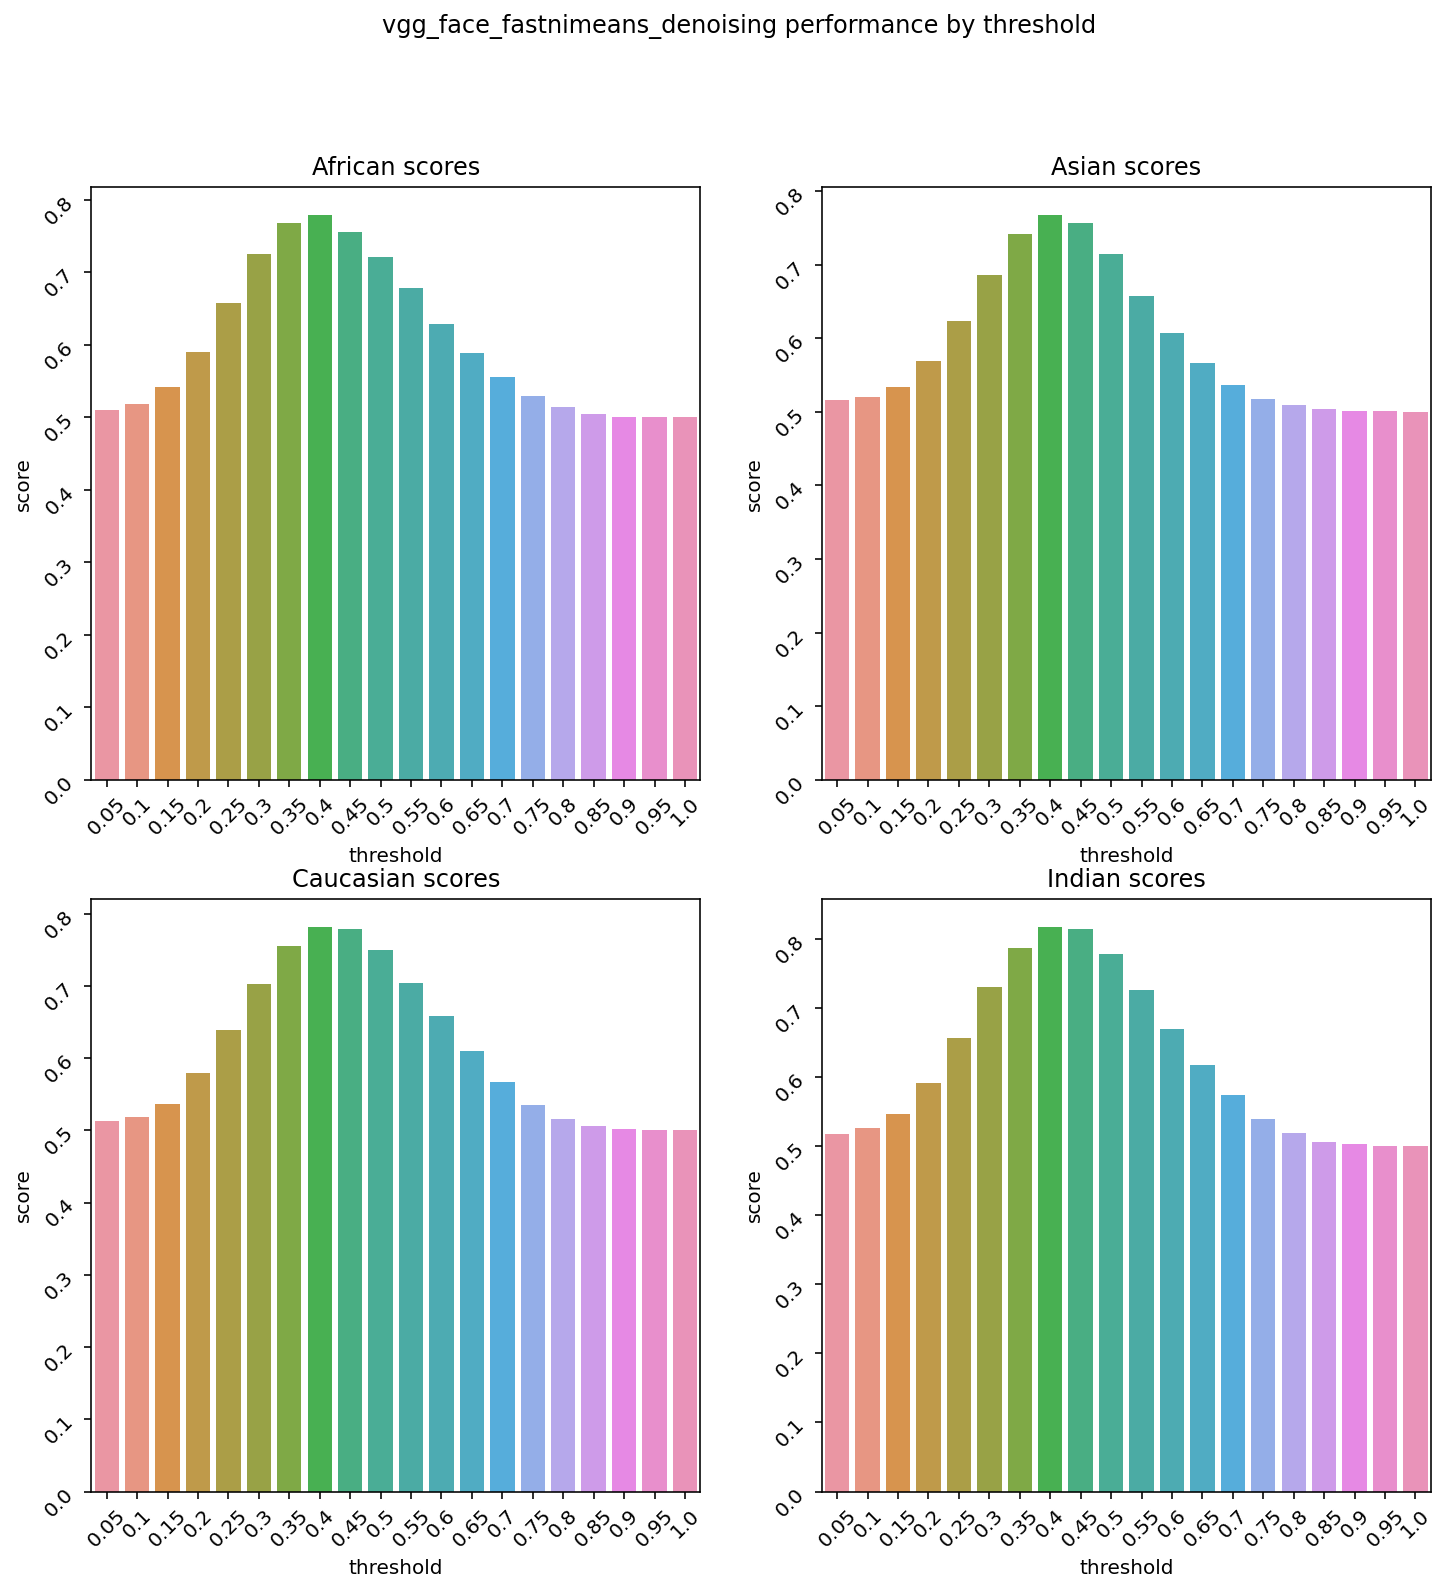

In [20]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [21]:
arcface_model = "arcface_fastnimeans_denoising"

In [22]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.826806,0.825184,0.828429
0,African,0.824578,0.823082,0.826074
0,Caucasian,0.817728,0.816129,0.819328
0,Asian,0.760078,0.758343,0.761812


In [23]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.650137,0.648404,0.651869
0,Caucasian,0.649987,0.648202,0.651771
0,African,0.647473,0.645832,0.649115
0,Asian,0.623880,0.622037,0.625723


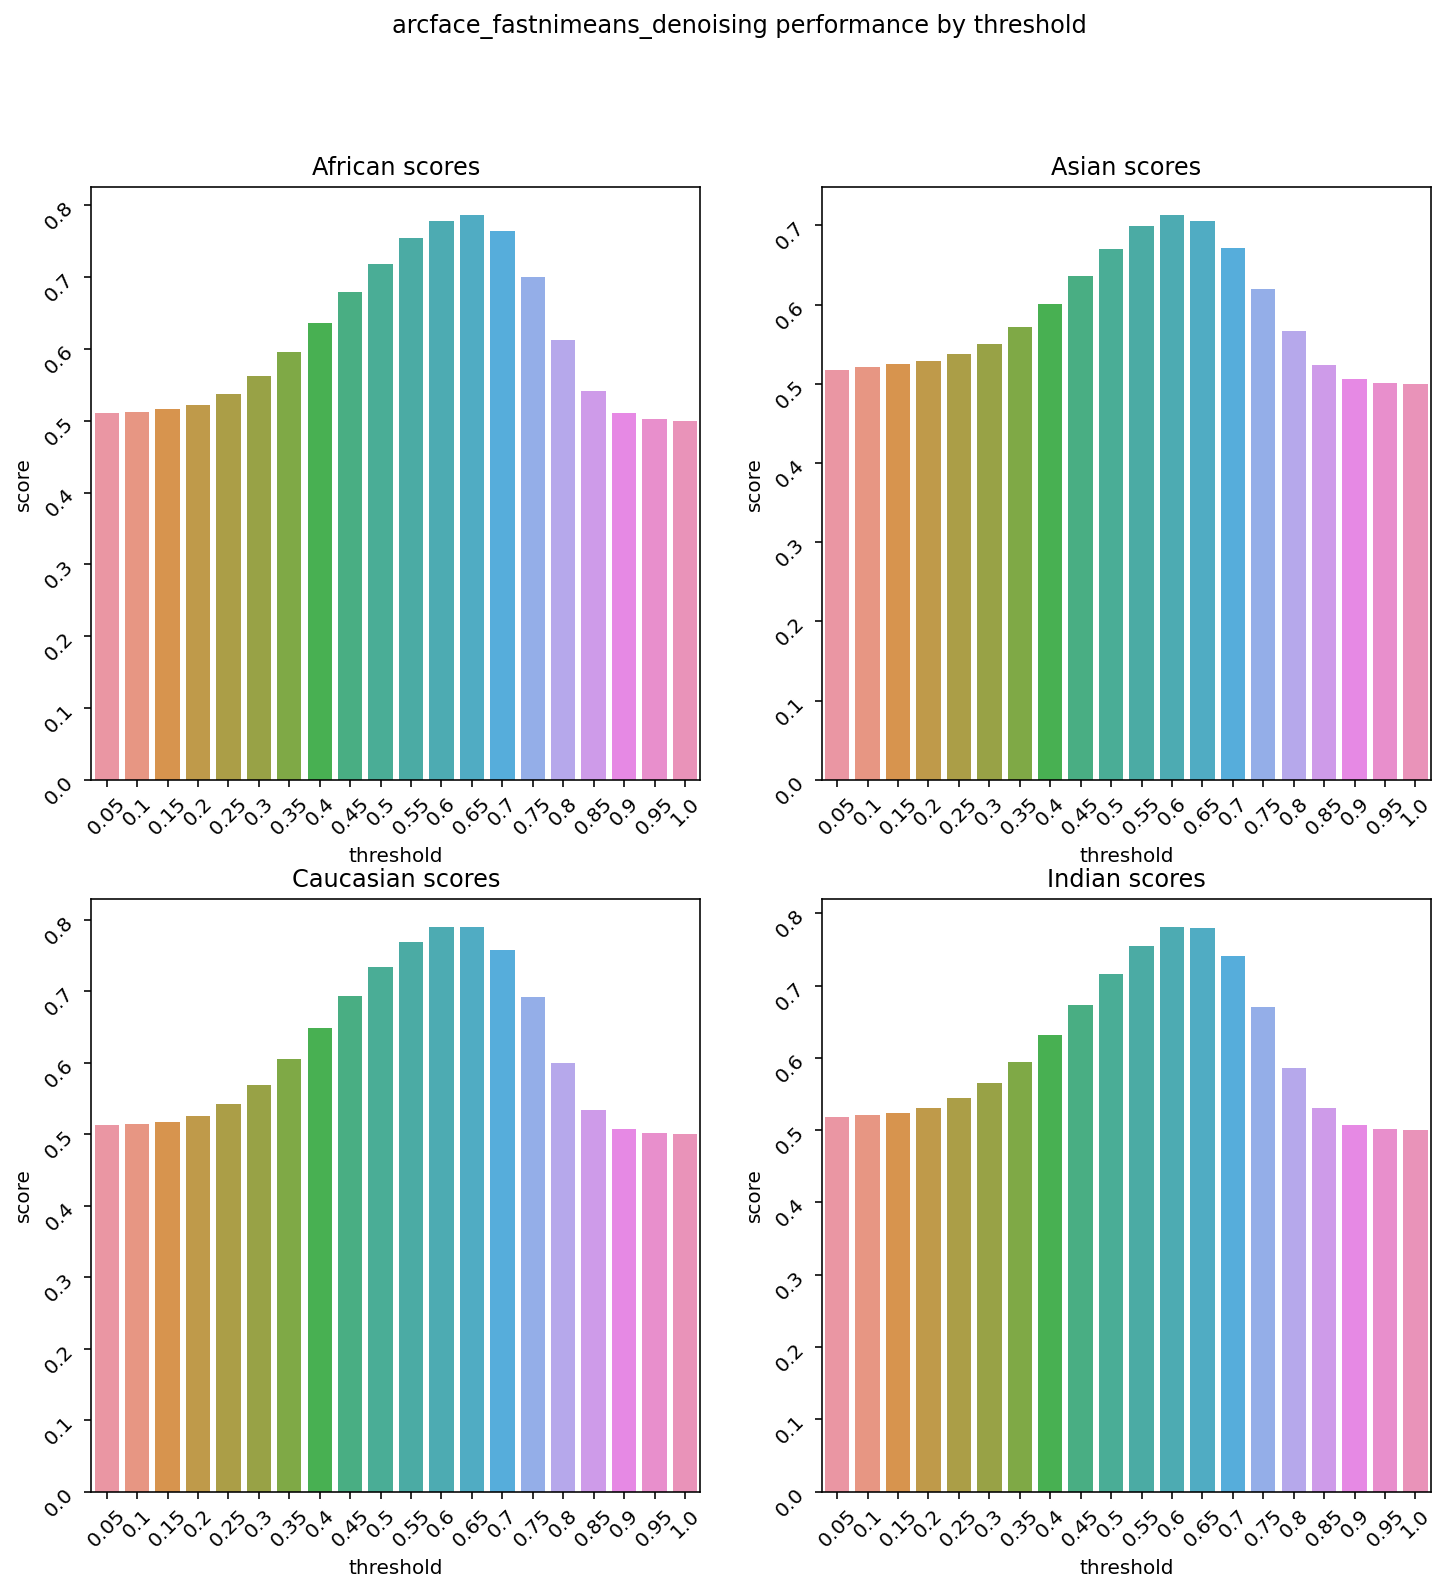

In [24]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

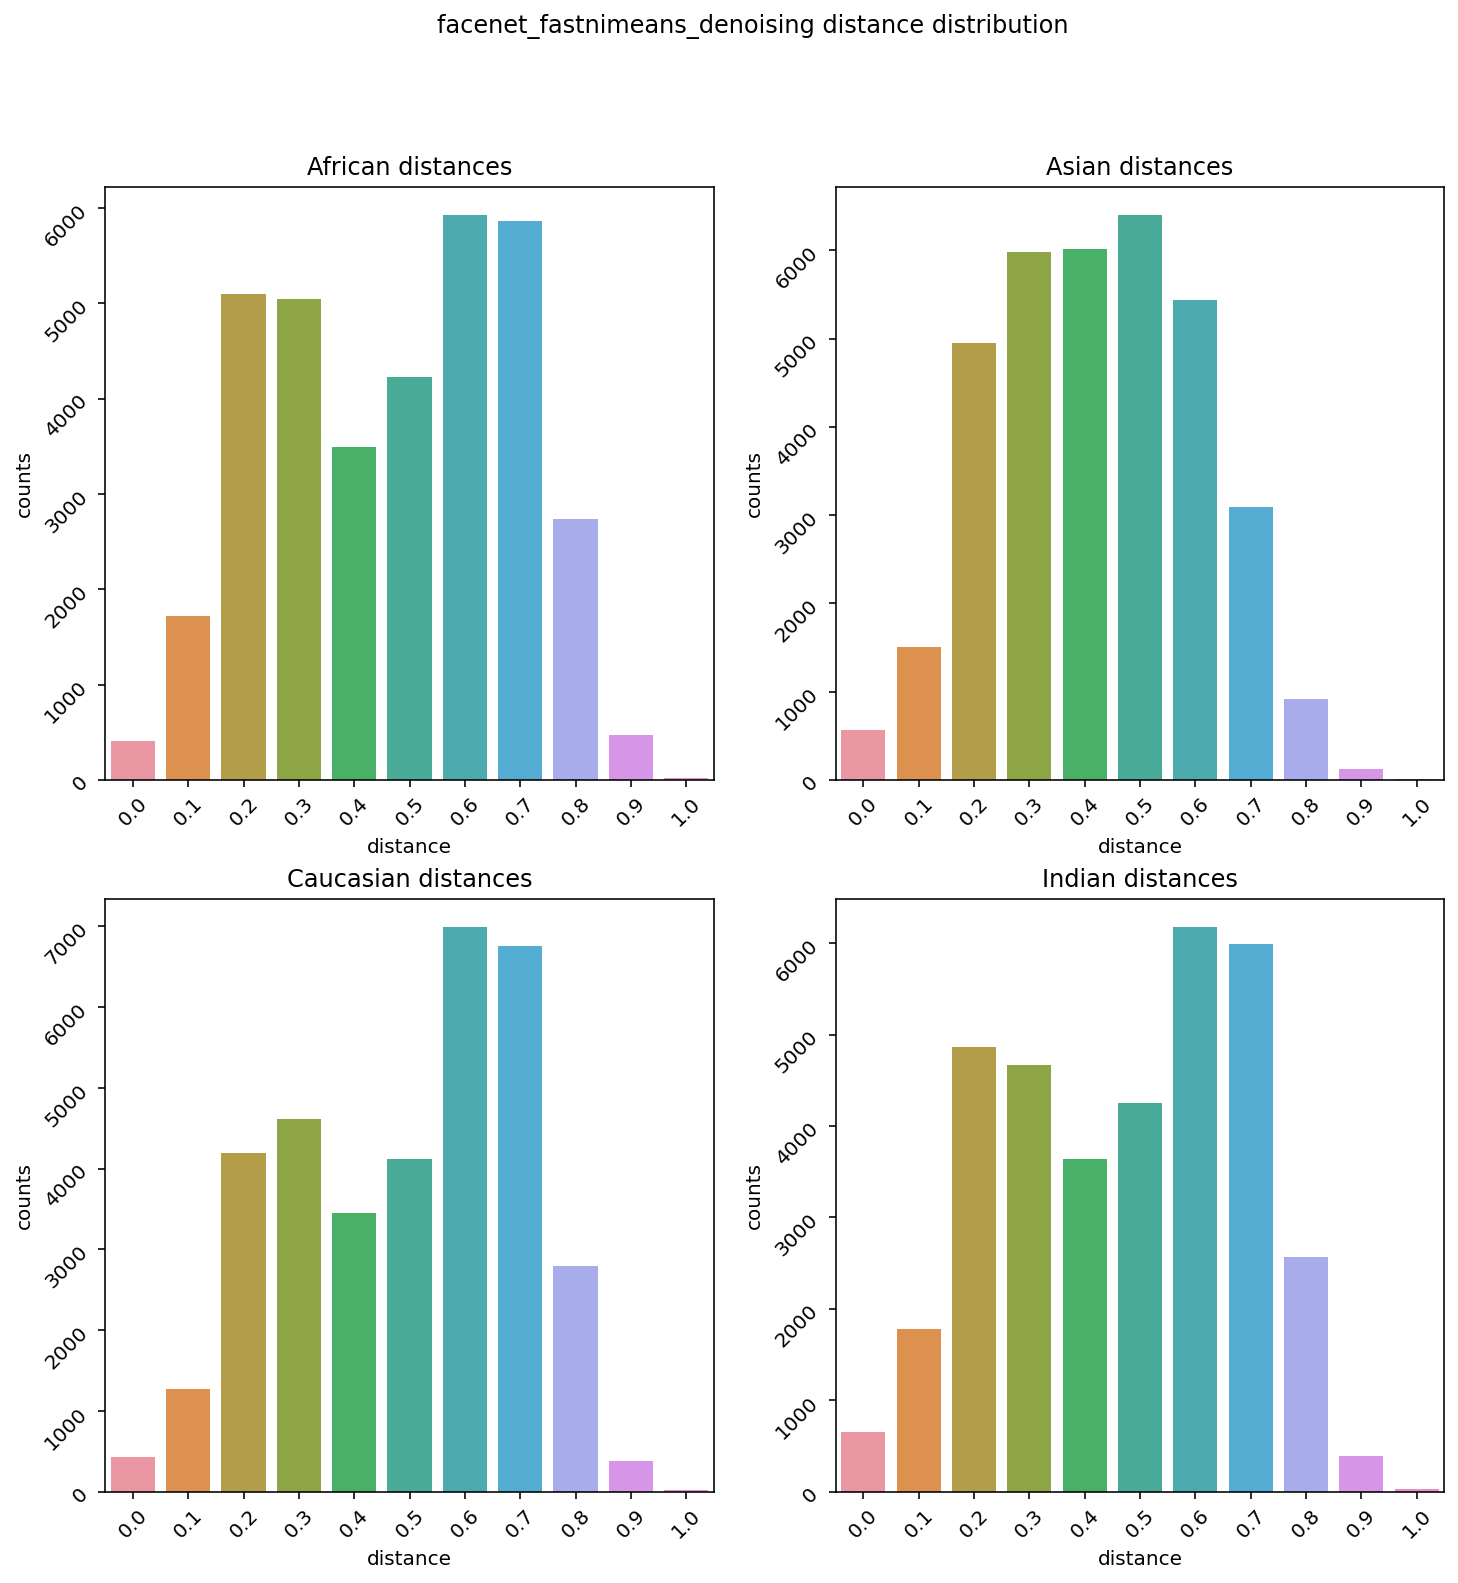

In [25]:
plot_score_distribution(facenet_model)

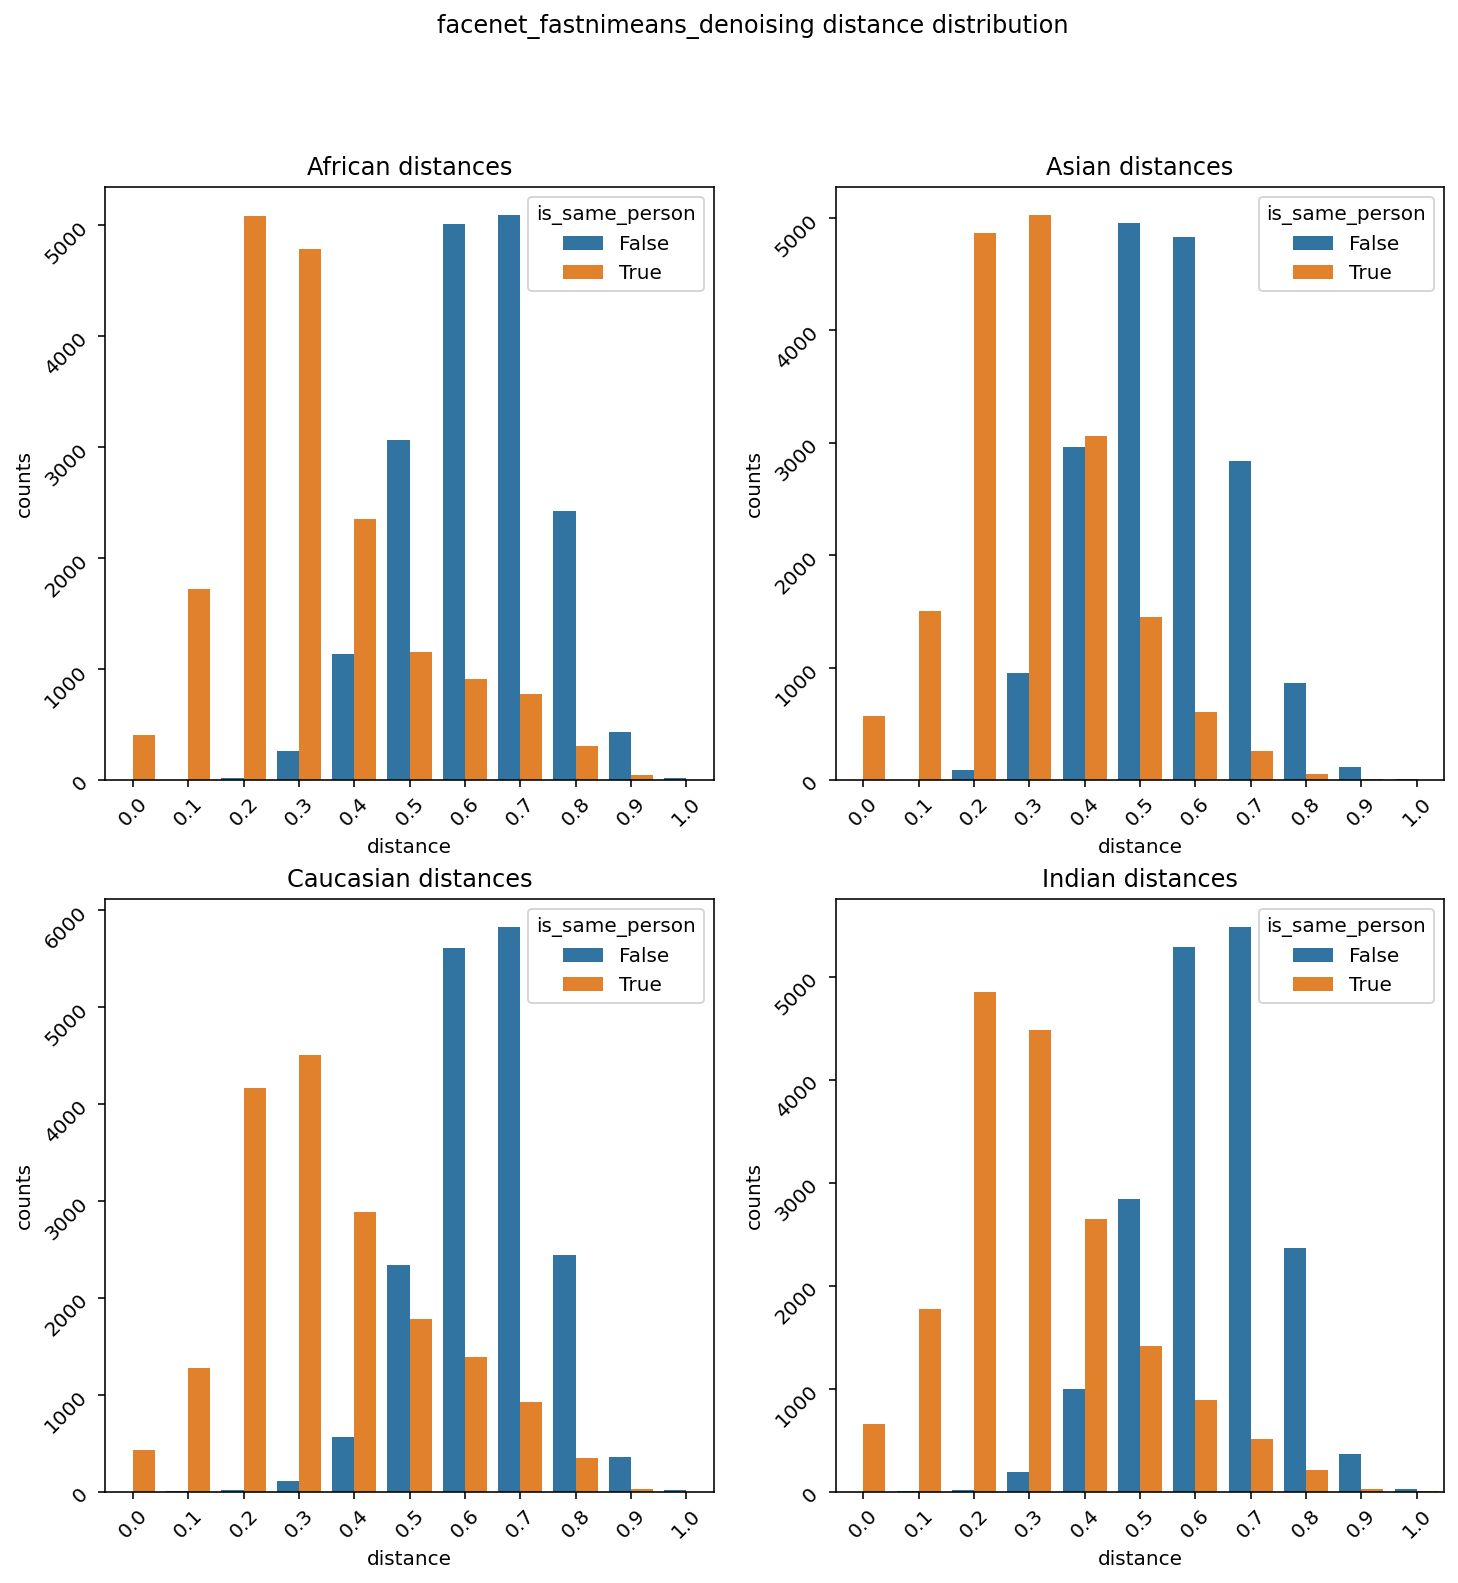

In [26]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [27]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

Asian difference in mean: -0.3439363856519796
African difference in mean: -0.4437692641544546
Caucasian difference in mean: -0.4444804146445238
Indian difference in mean: -0.45746650660589794


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


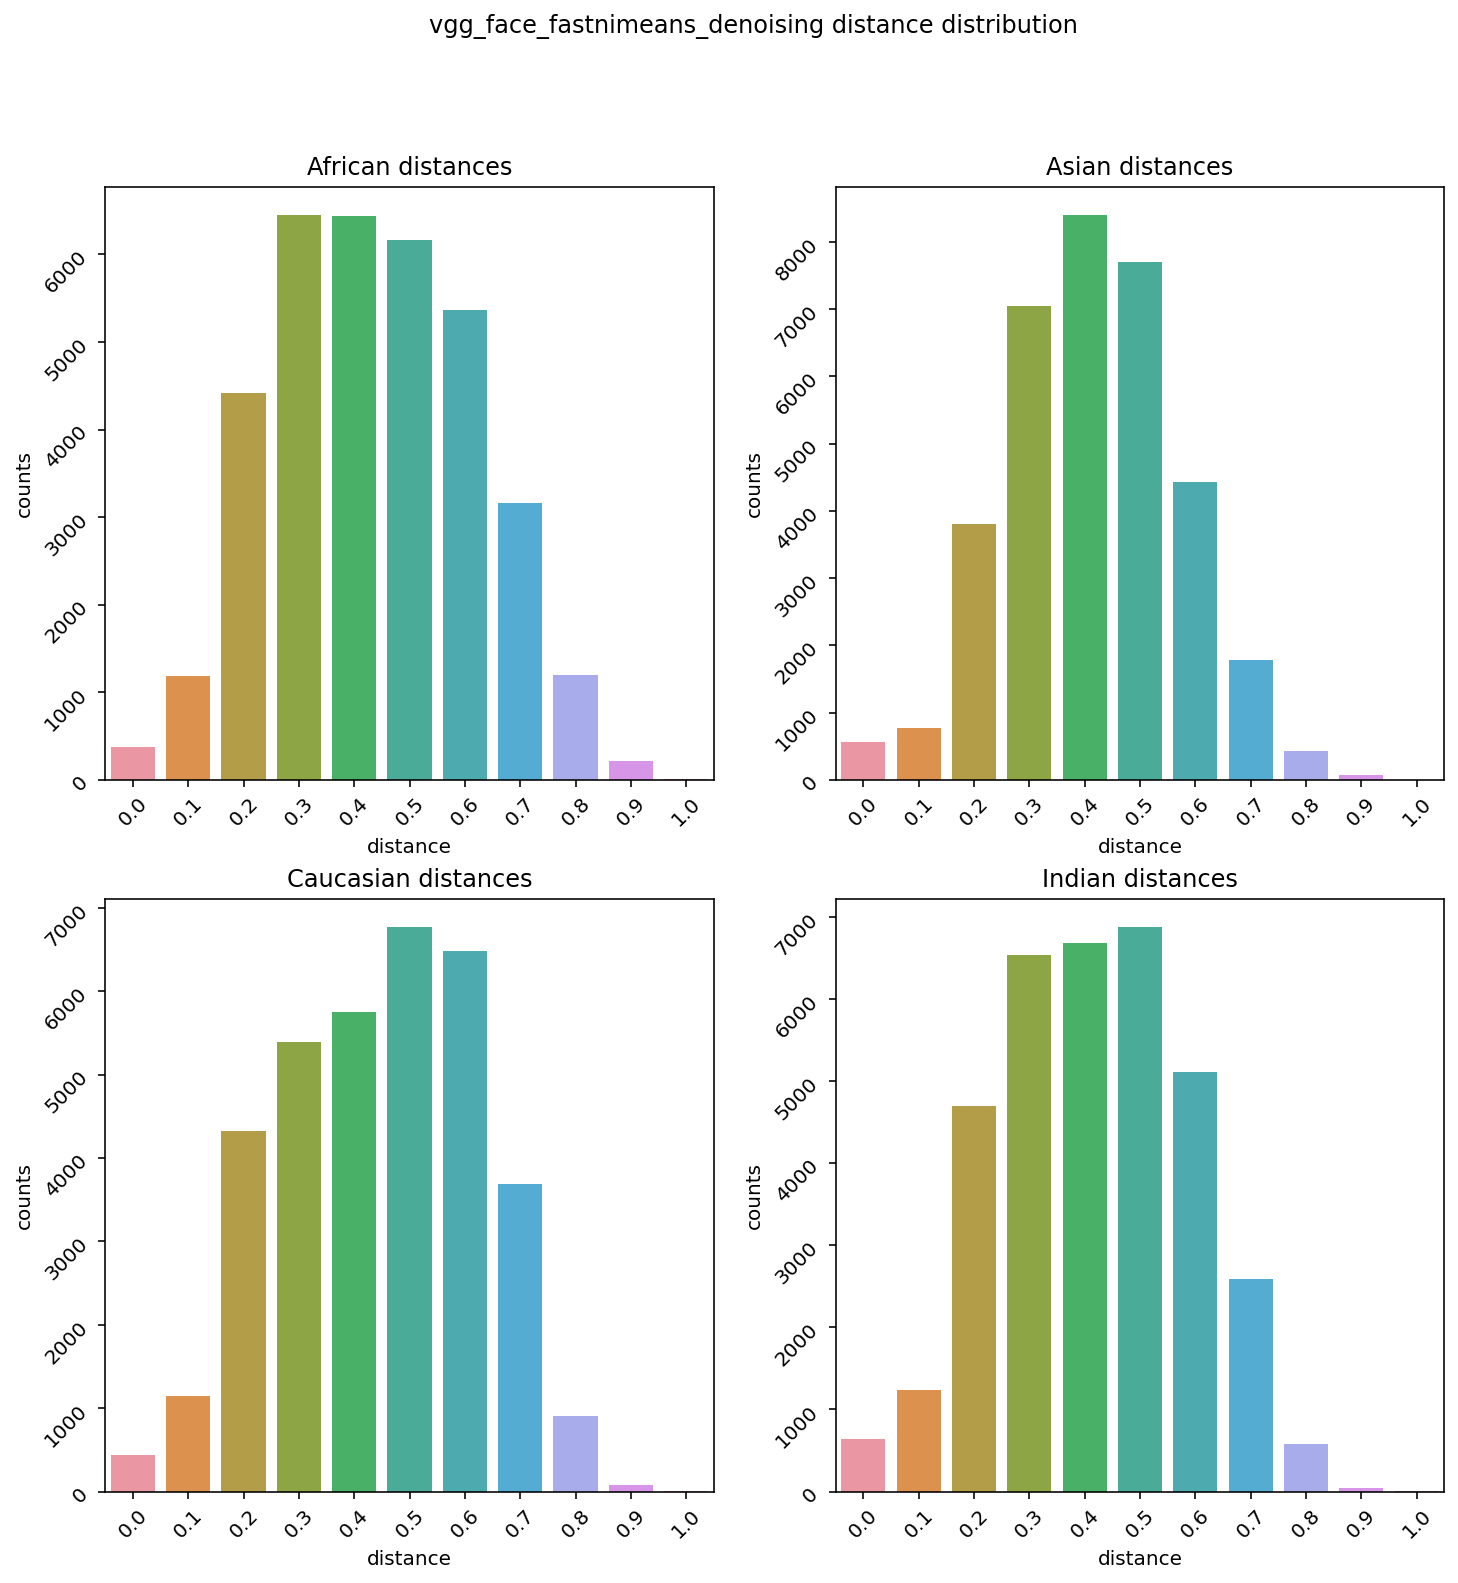

In [28]:
plot_score_distribution(vgg_face_model)

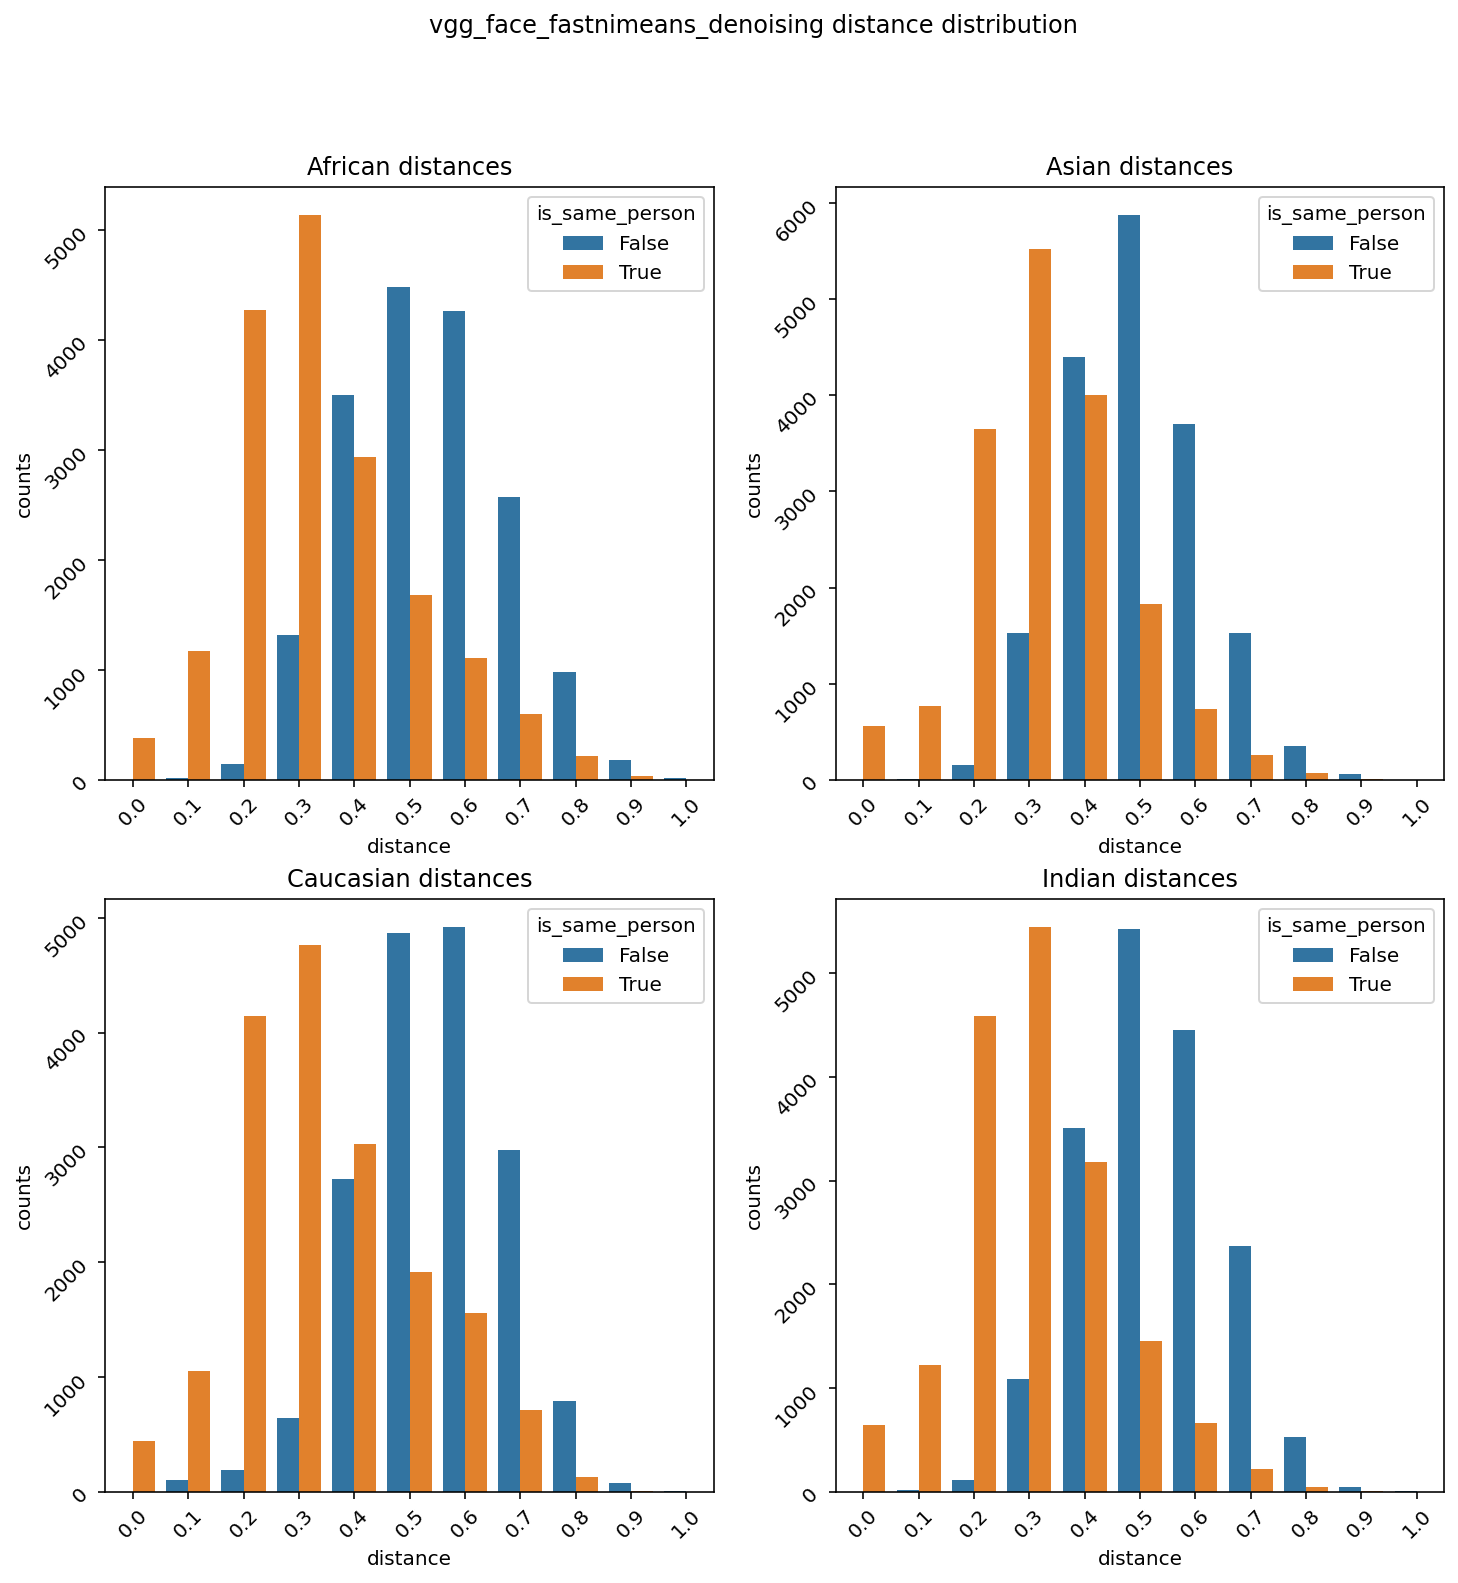

In [29]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [30]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

Asian difference in mean: -0.16530626391939968
African difference in mean: -0.20175337770545487
Caucasian difference in mean: -0.22818337005505052
Indian difference in mean: -0.2389687631459369


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

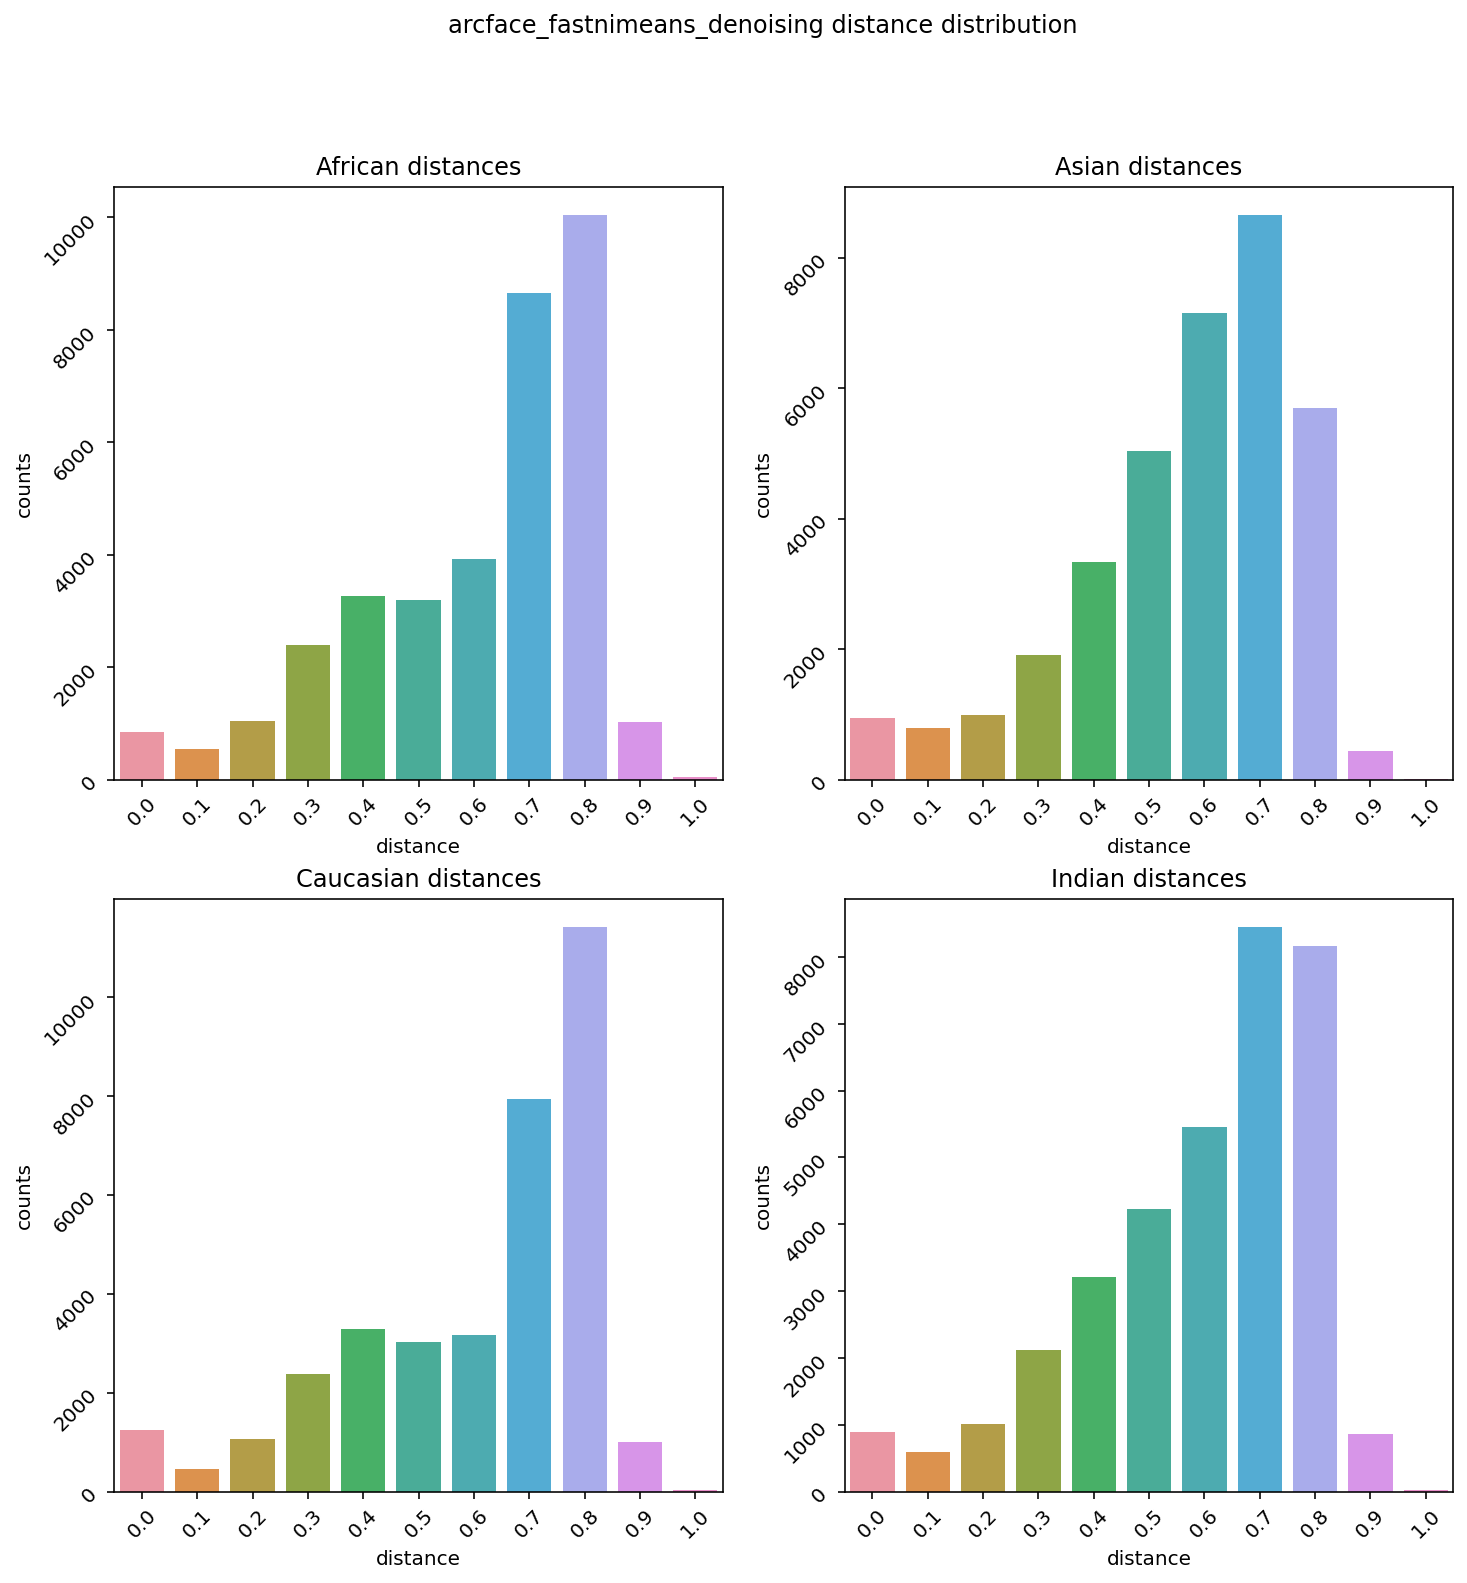

In [31]:
plot_score_distribution(arcface_model)

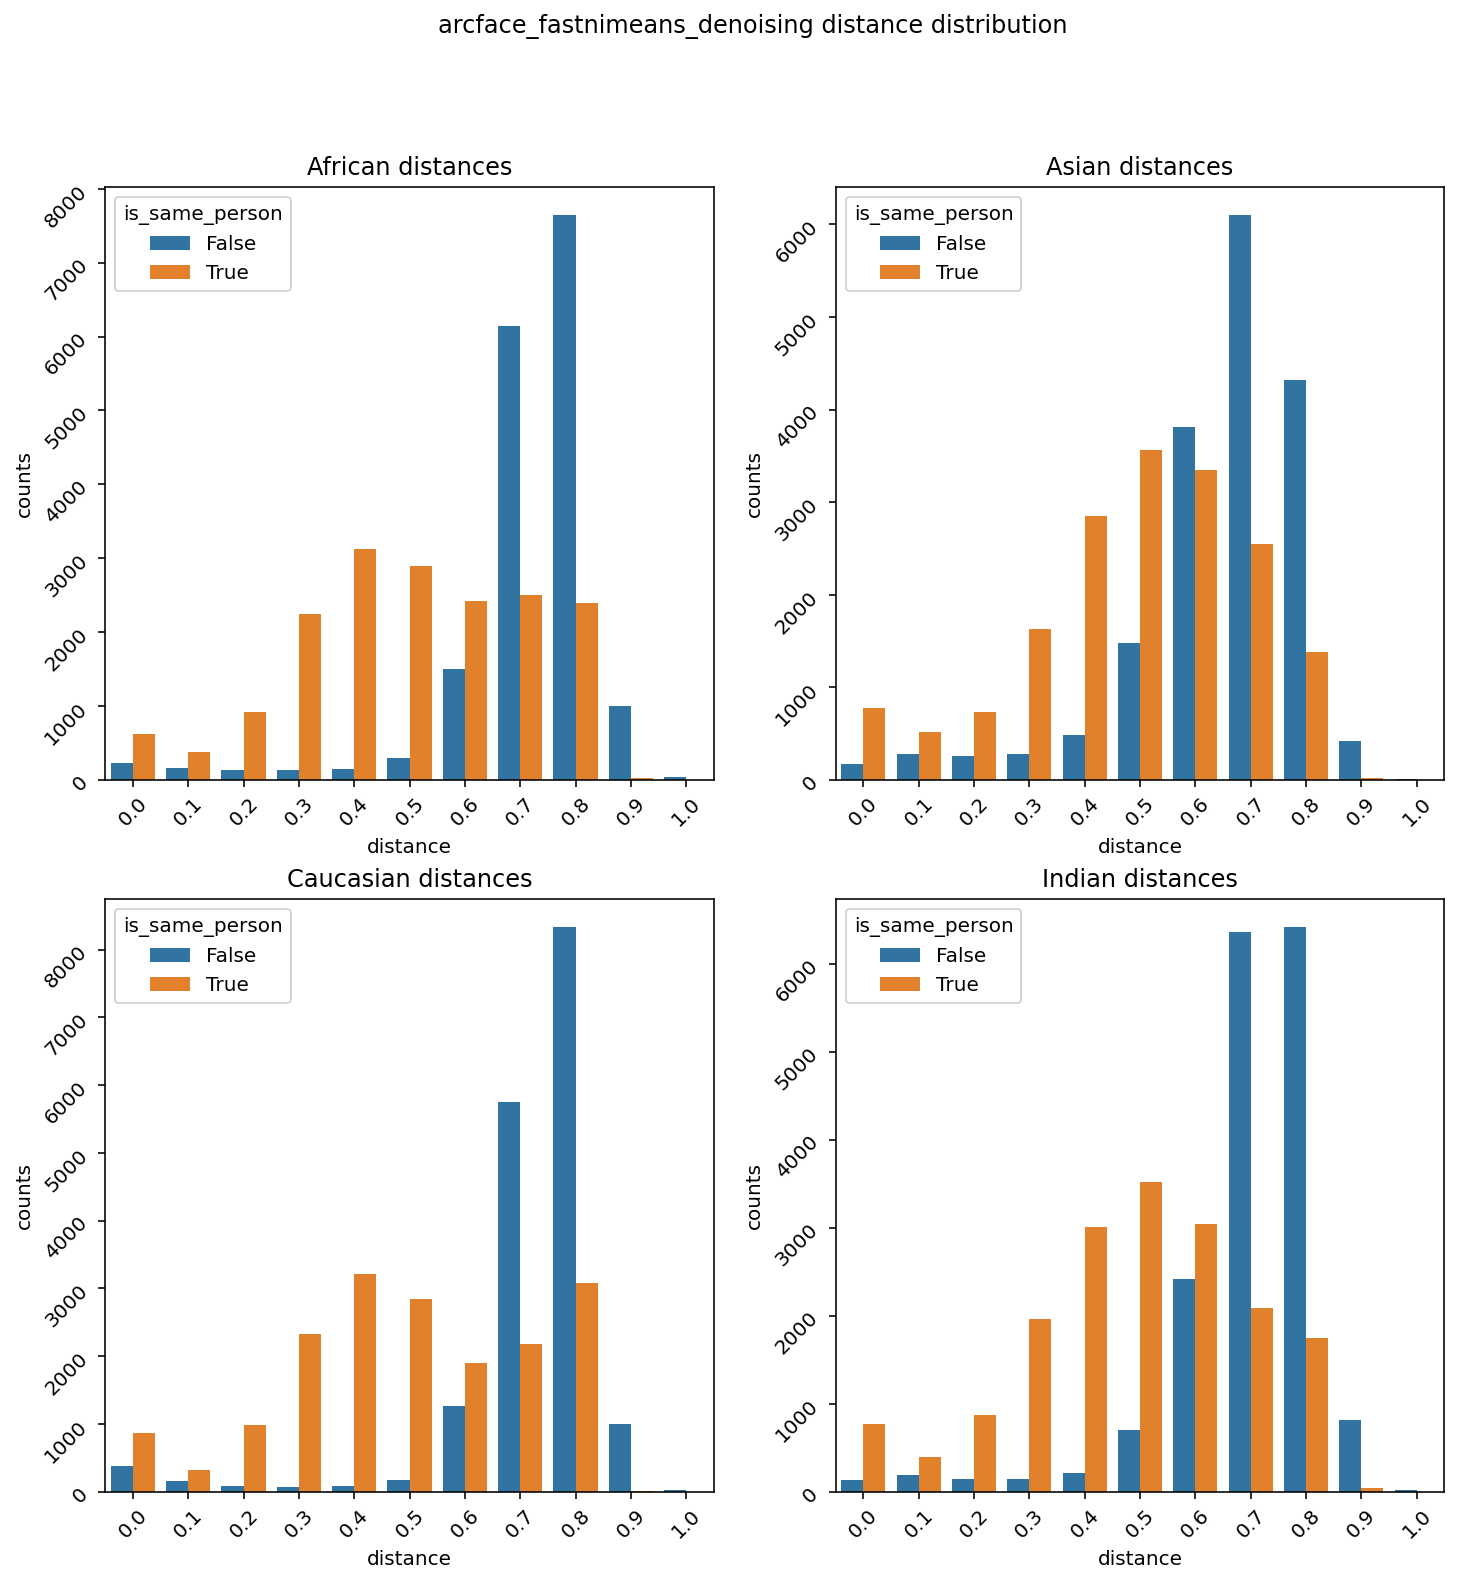

In [32]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [33]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

Asian difference in mean: -0.19348137317395375
African difference in mean: -0.2729322894797124
Caucasian difference in mean: -0.284551969400082
Indian difference in mean: -0.2593721486517637


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [34]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [35]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [36]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

Wilcoxon test on Caucasian performance: 0.0012367634018782935
Wilcoxon test on Asian performance: 3.1168218999182863e-09
Wilcoxon test on African performance: 2.9367061377804793e-15
Wilcoxon test on Indian performance: 1.3646048744409376e-33


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [37]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  0.006919359332208475
Wilcoxon test on Asian performance:  0.7050352651403038
Wilcoxon test on African performance:  0.07143529499089181
Wilcoxon test on Indian performance:  9.825786210489427e-44


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [38]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  1.727351990829558e-05
Wilcoxon test on Asian performance:  7.071073148780665e-127
Wilcoxon test on African performance:  3.0476781116530145e-05
Wilcoxon test on Indian performance:  1.5952673162667652e-09


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [39]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [41]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = fastnimeans_denoising)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = fastnimeans_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = fastnimeans_denoising)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = fastnimeans_denoising)

In [42]:
facenet512 = DeepFace.build_model("Facenet512")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 19.496349526541856
Prediction_local [12.29785381]
Right: 12.180204
Intercept 20.616772139403924
Prediction_local [13.72269832]
Right: 13.55997


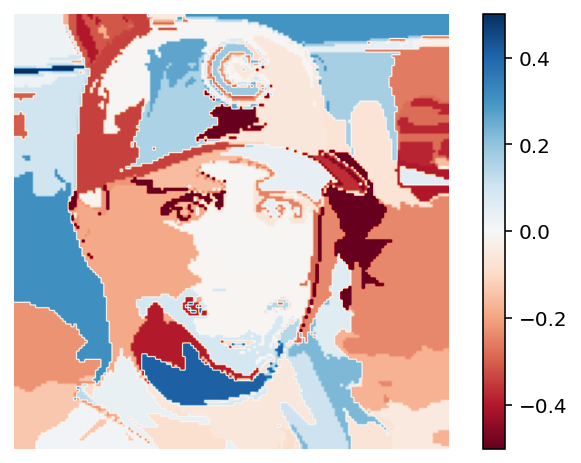

In [43]:
plot_face_heatmap(facenet512, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 21.835696781849133
Prediction_local [19.12369243]
Right: 19.2853
Intercept 26.469182987903633
Prediction_local [21.07425944]
Right: 20.902197


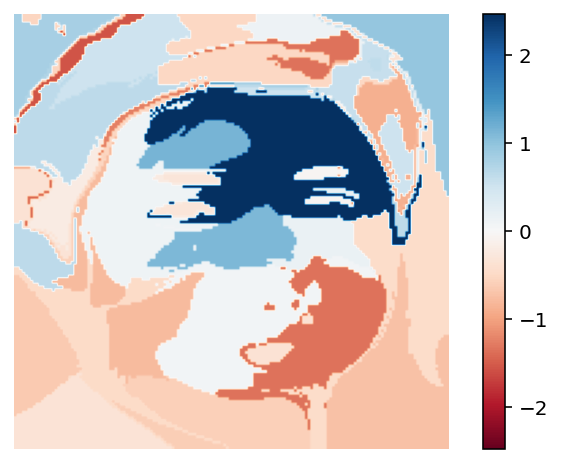

In [44]:
plot_face_heatmap(facenet512, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 17.35180156947606
Prediction_local [10.66916218]
Right: 10.4377775
Intercept 19.414961671077627
Prediction_local [11.08095559]
Right: 10.649512


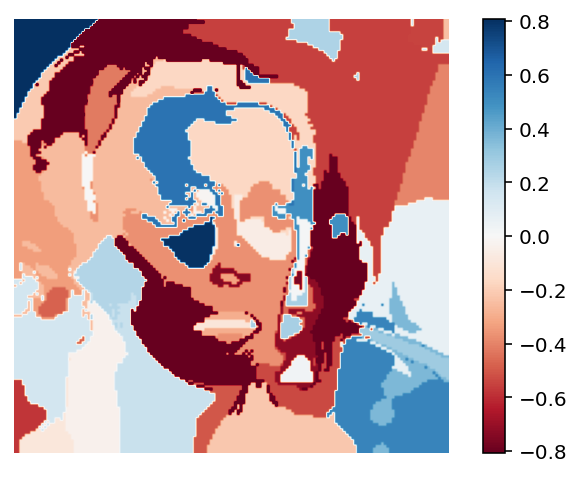

In [45]:
plot_face_heatmap(facenet512, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 31.471213592840485
Prediction_local [16.86997411]
Right: 16.523438
Intercept 22.853154677067252
Prediction_local [16.97419669]
Right: 16.743132


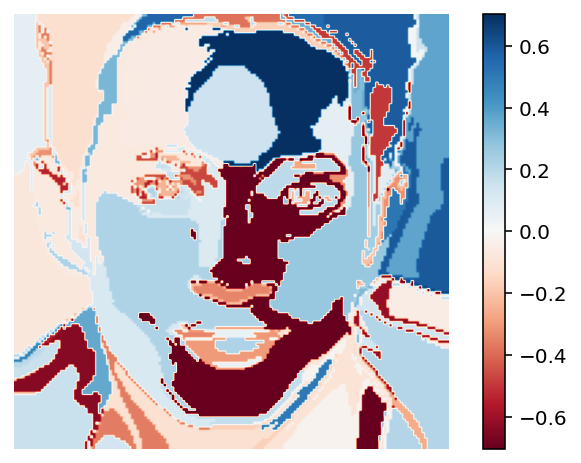

In [46]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [48]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = fastnimeans_denoising)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = fastnimeans_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = fastnimeans_denoising)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = fastnimeans_denoising)

In [49]:
vgg_face = DeepFace.build_model("VGG-Face")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 1.2683412178872597
Prediction_local [11.3783833]
Right: 11.554471
Intercept -3.290121523679141
Prediction_local [12.28992374]
Right: 12.526814


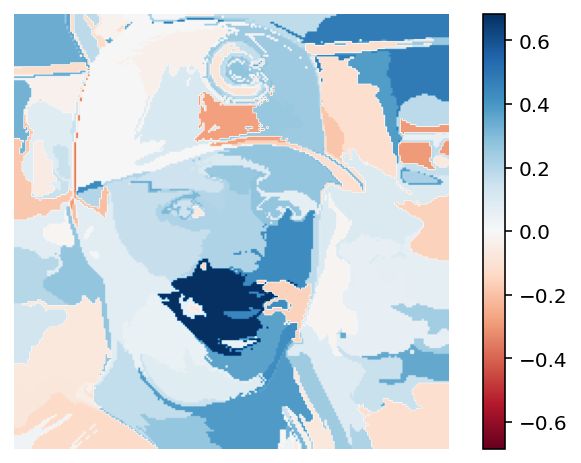

In [50]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.7986919766161815
Prediction_local [11.35872451]
Right: 11.554471
Intercept -3.027575810789588
Prediction_local [12.28110317]
Right: 12.526814


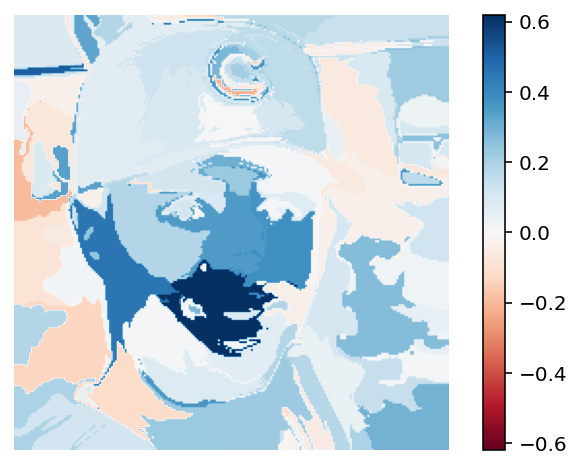

In [51]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -2.4047483460176453
Prediction_local [13.76135367]
Right: 14.0694275
Intercept -3.4111187735593393
Prediction_local [13.84746175]
Right: 14.226264


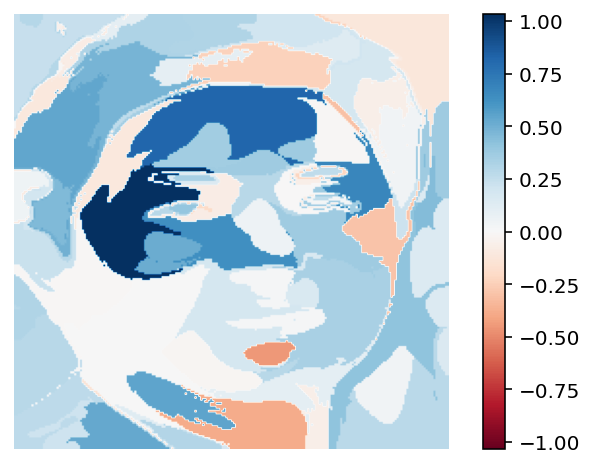

In [52]:
plot_face_heatmap(vgg_face, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -13.838258609496506
Prediction_local [14.85256187]
Right: 15.798002
Intercept -11.37705870057867
Prediction_local [17.12431209]
Right: 17.98131


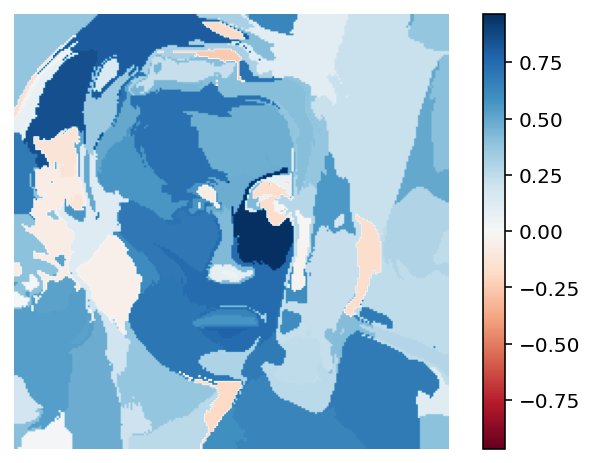

In [53]:
plot_face_heatmap(vgg_face, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -3.6971782136794227
Prediction_local [11.58274426]
Right: 11.780462
Intercept -6.988288902769982
Prediction_local [12.15151184]
Right: 12.428108


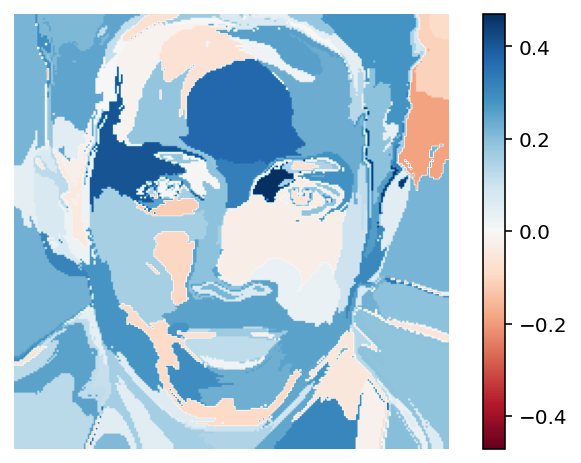

In [54]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [55]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = fastnimeans_denoising)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = fastnimeans_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = fastnimeans_denoising)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = fastnimeans_denoising)

In [56]:
arcface = DeepFace.build_model("ArcFace")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 336.6137773894633
Prediction_local [954.52885524]
Right: 971.3533
Intercept 498.4657358541531
Prediction_local [1194.54692227]
Right: 1213.0144


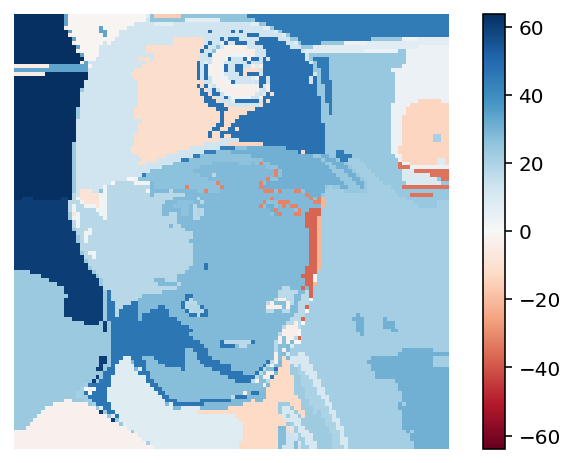

In [57]:
plot_face_heatmap(arcface, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 1056.811922395129
Prediction_local [1535.21985361]
Right: 1517.6996
Intercept 352.31168837688404
Prediction_local [1769.11567571]
Right: 1812.8816


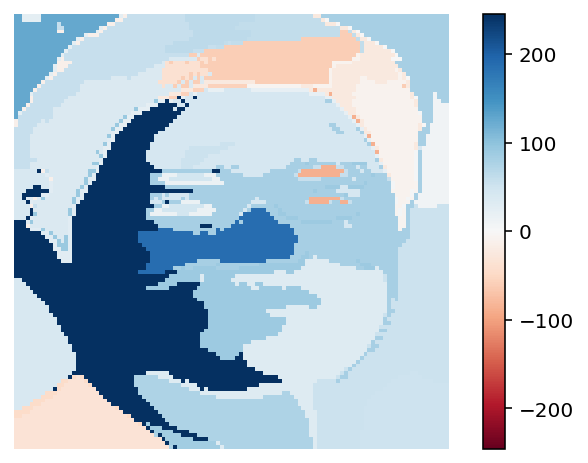

In [58]:
plot_face_heatmap(arcface, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 371.6021797820265
Prediction_local [901.9897663]
Right: 906.00824
Intercept 652.9817150736678
Prediction_local [1159.77748979]
Right: 1148.7612


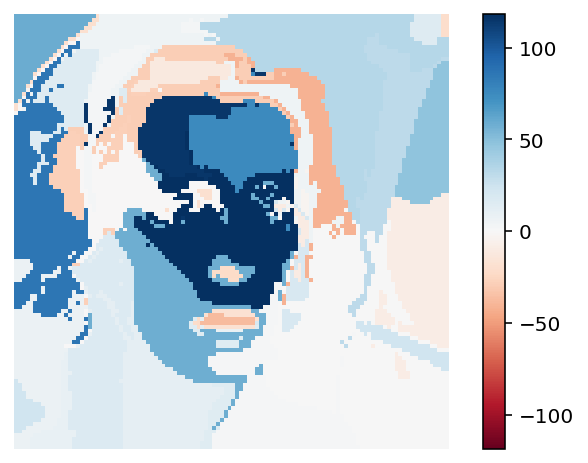

In [59]:
plot_face_heatmap(arcface, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 486.66889879733185
Prediction_local [1104.21132903]
Right: 1113.0504
Intercept 864.9498737523527
Prediction_local [1486.4213122]
Right: 1495.69


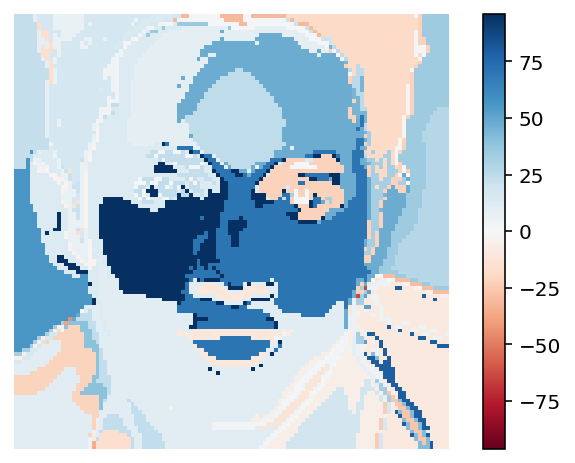

In [60]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others